In [3]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('./PRSA_Data_Aotizhongxin_20130301-20170228.csv')
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


In [4]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df["wd"])
df["cat_wd"] = le.transform(df["wd"])
print(list(le.classes_))
df = df.drop(['wd'], axis=1)

['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE', 'SSW', 'SW', 'W', 'WNW', 'WSW', nan]


In [5]:
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,station,cat_wd
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,4.4,Aotizhongxin,6
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,4.7,Aotizhongxin,3
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,5.6,Aotizhongxin,6
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,3.1,Aotizhongxin,7
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,2.0,Aotizhongxin,3


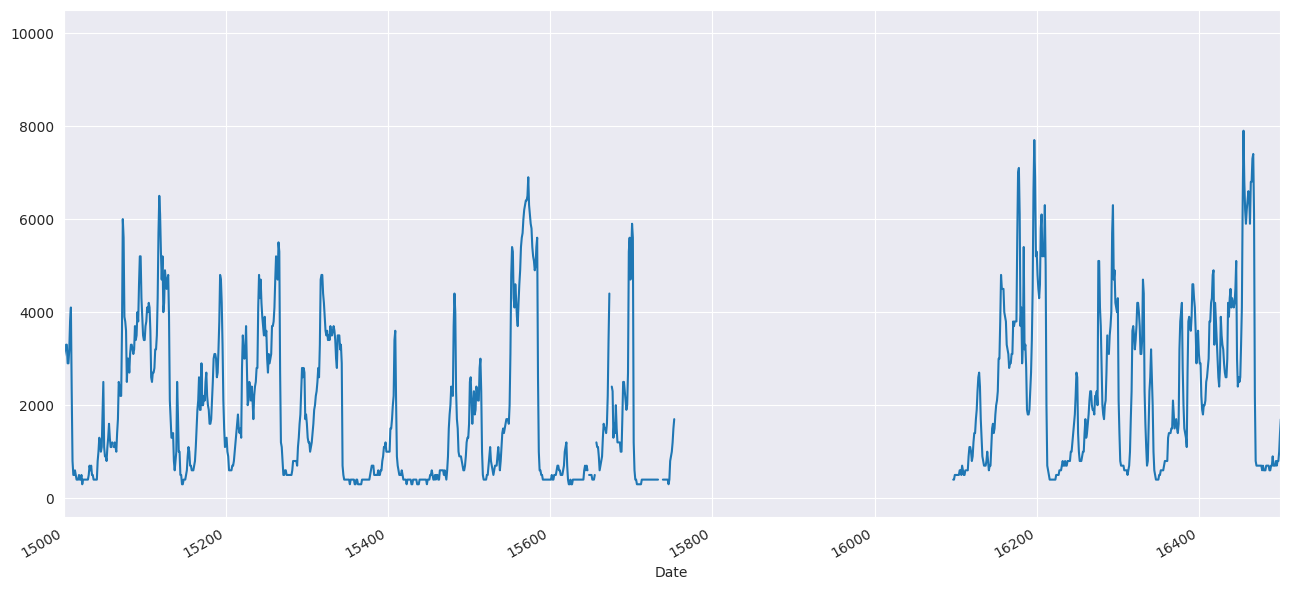

In [6]:
fig, ax = plt.subplots(figsize=(13,6))

ax.plot(df['CO'])
ax.set_xlabel('Date')
plt.xlim(15000, 16500)

fig.autofmt_xdate()
plt.tight_layout()

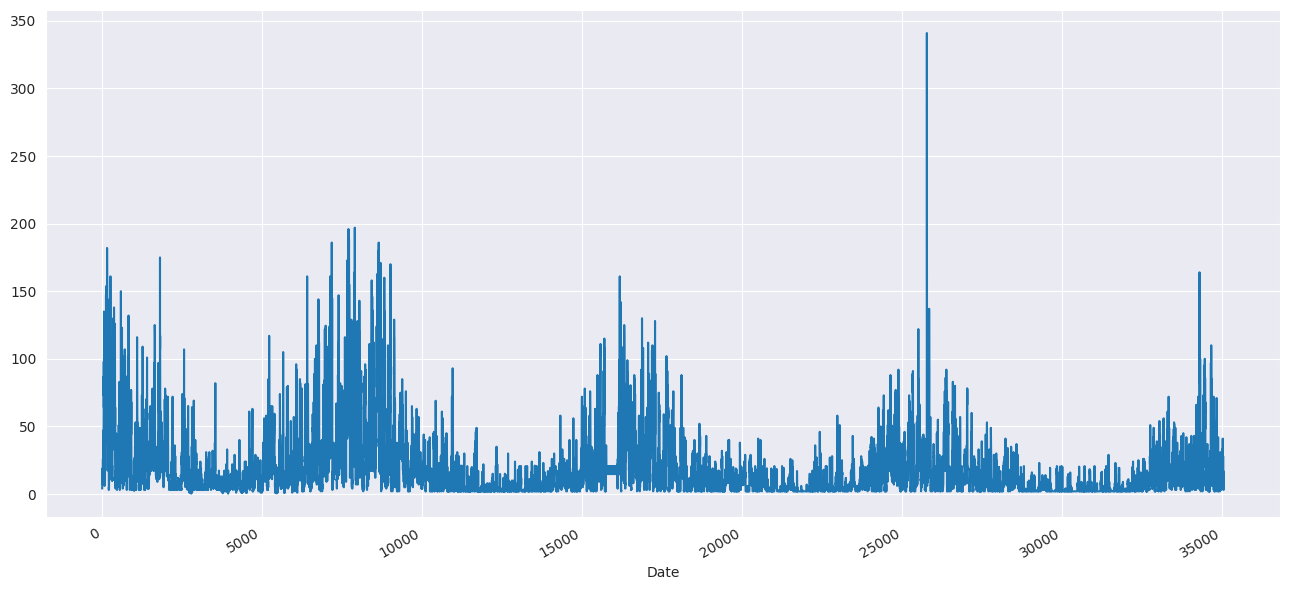

In [17]:
tf.random.set_seed(42)
np.random.seed(42)

fig, ax = plt.subplots(figsize=(13,6))

ax.plot(df['SO2'])
ax.set_xlabel('Date')

fig.autofmt_xdate()
plt.tight_layout()

In [8]:
df.loc[:,'datetime'] = pd.to_datetime(df[['year','month','day','hour']])

In [9]:
df = df.drop(['year', 'month', 'day', 'hour'], axis=1)

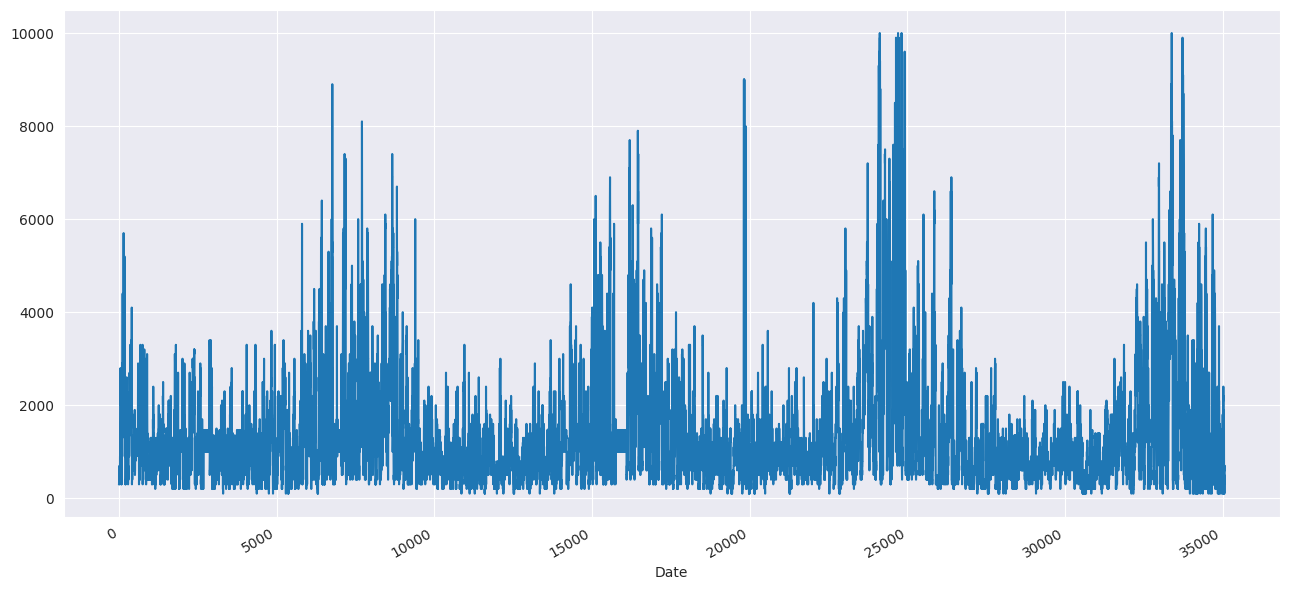

In [10]:
df = df.fillna(df.groupby(df.datetime.dt.hour).transform('mean'))
fig, ax = plt.subplots(figsize=(13,6))

ax.plot(df['CO'])
ax.set_xlabel('Date')

fig.autofmt_xdate()
plt.tight_layout()

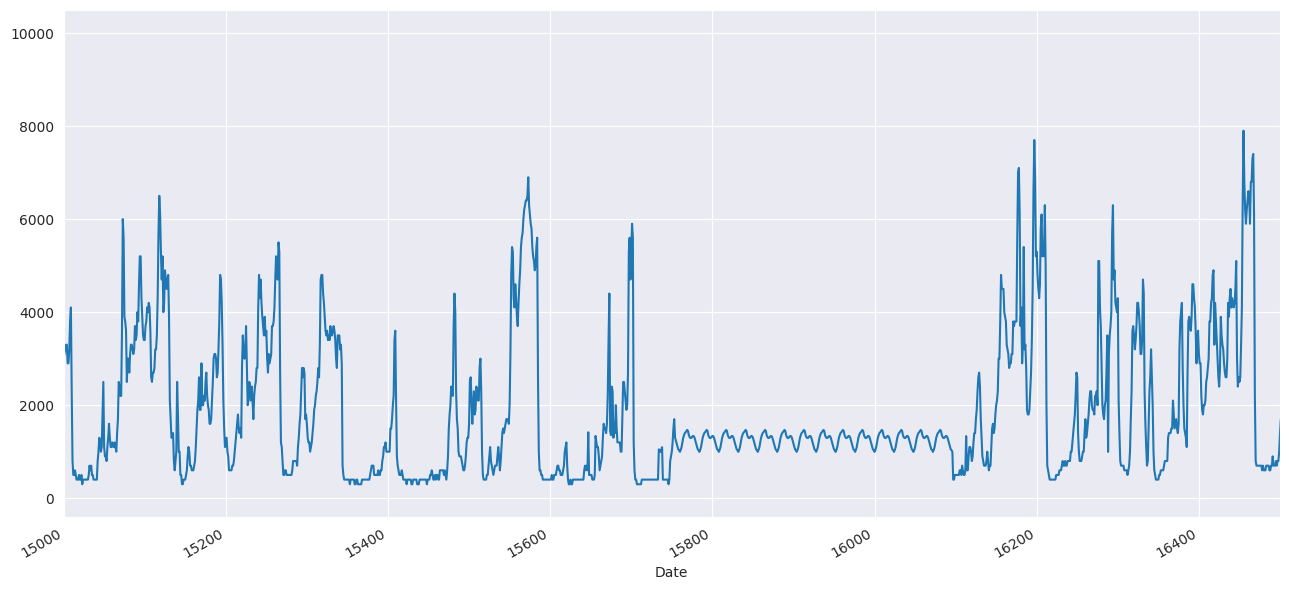

In [11]:
fig, ax = plt.subplots(figsize=(13,6))

ax.plot(df['CO'])
ax.set_xlabel('Date')
plt.xlim(15000, 16500)

fig.autofmt_xdate()
plt.tight_layout()

In [12]:
df.isna().sum()

No          0
PM2.5       0
PM10        0
SO2         0
NO2         0
CO          0
O3          0
TEMP        0
PRES        0
DEWP        0
RAIN        0
WSPM        0
station     0
cat_wd      0
datetime    0
dtype: int64

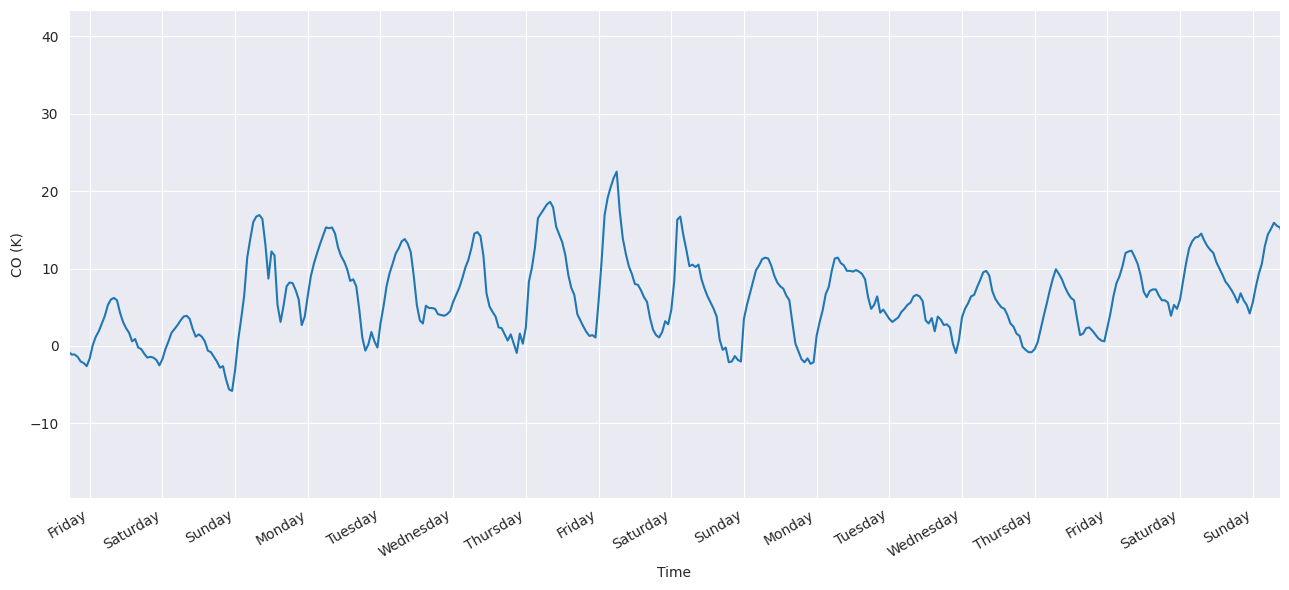

In [24]:
fig, ax = plt.subplots(figsize=(13,6))

ax.plot(df['TEMP'])
ax.set_xlabel('Time')
ax.set_ylabel('CO (K)')

plt.xticks(np.arange(7, 400, 24), ['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlim(0, 400)

fig.autofmt_xdate()
plt.tight_layout()

In [27]:
timestamp_s = pd.to_datetime(df['datetime']).map(datetime.datetime.timestamp)

day = 24 * 60 * 60

df['day_sin'] = (np.sin(timestamp_s * (2*np.pi/day))).values
df['day_cos'] = (np.cos(timestamp_s * (2*np.pi/day))).values


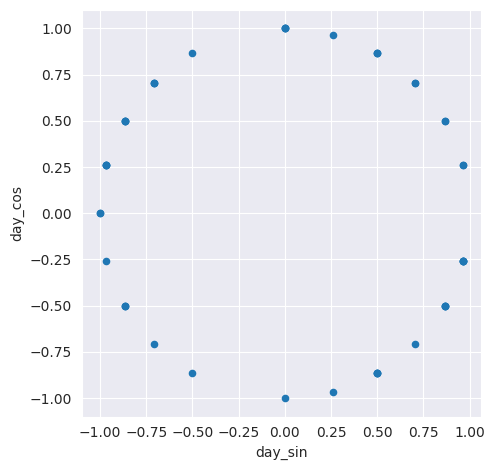

In [28]:
df.sample(50).plot.scatter('day_sin','day_cos').set_aspect('equal');
plt.tight_layout()

In [34]:
#df = df.drop(['station'], axis=1)
df = df.drop(['datetime'], axis=1)


n = len(df)

# Split 70:20:10 (train:validation:test)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

train_df.shape, val_df.shape, test_df.shape

((24544, 15), (7013, 15), (3507, 15))

Before saving the data, we must scale it so all values are between 0 and 1. This decreases the time required for training deep learning models, and it improves their performance. We’ll use MinMaxScaler from sklearn to scale our data.
Note that we will fit the scaler on the training set to avoid data leakage. That way, we are simulating the fact that we only have the training data available when we’re using the model, and no future information is known by the model. The evaluation of the model remains unbiased.

In [35]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_df)

train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

It is worth mentioning why the data is scaled and not normalized. Scaling and normalization can be confusing terms for data scientists, as they are often used interchangeably.
In short, scaling the data affects only its scale and not its distribution. Thus, it simply forces the values into a certain range. In our case, we force the values to be between 0 and 1.
Normalizing the data, on the other hand, affects its distribution and its scale. Thus, normalizing the data would force it to have a normal distribution or a Gaussian distribution. The original range would also change, and plotting the frequency of each value would generate a classic bell curve.
Normalizing the data is only useful when the models we use require the data to be normal. For example, linear discriminant analysis (LDA) is derived from the assumption of a normal distribution, so it is better to normalize data before using LDA. However, in the case of deep learning, no assumptions are made, so normalizing is not required.
Finally, we’ll save each set as a CSV file for use in the following chapters.

In [36]:
train_df.to_csv('./train.csv')
val_df.to_csv('./val.csv')
test_df.to_csv('./test.csv')